In [66]:
# Import statements
%pip install pykrige
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
from pykrige.ok import OrdinaryKriging
from sklearn.preprocessing import MinMaxScaler

Note: you may need to restart the kernel to use updated packages.


In [31]:
# Read in file
filename = 'sweetspot_UT_Austin.csv'
df = pd.read_csv(filename)

In [32]:
# Size and top 8 rows in dataset
print('Data size:', df.shape)
df.head(n=8)

Data size: (55, 14)


,Well Number,Well Name,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
0,1,PO1_1,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3,3491.971374,2992.403113
1,2,PO1_2,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,4,3501.327981,2947.374808
2,3,PO1_3,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,4,3493.763065,2904.053641
3,4,PO1_4,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,5,3519.775759,3301.826052
4,5,PO1_5,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,5,3547.347889,3365.597401
5,6,PO1_6,10272.76,11141.88,0.995444,3.840000e-07,0.071007,0.000168,0.000168,8555.5,2.792220,5,3493.232193,3196.746890
6,7,PO1_7,11430.25,11141.88,0.215019,6.030030e-01,0.069382,0.000162,0.000162,8589.1,0.523657,5,3504.380491,3126.405930
7,8,PO1_8,12877.11,11141.88,0.000000,1.244600e+00,0.074247,0.000270,0.000270,8638.6,0.000000,5,3520.804323,2949.434450


In [33]:
# Well number and name are redundant (can use row index) and can be removed.
df.drop(columns=['Well Number', 'Well Name'], inplace=True)

In [34]:
# Rename column headers to be more human-readable
mappings = {
    'Bottomhole X': 'bh_x',         # Bottomhole X-coordinate
    'Bottomhole Y': 'bh_y',         # Bottomhole Y-coordinate
    'Co [MSTB]':'oil_prod_mstb',    # Cumulative oil production, thousand stock tank barrels
    'Cw (bbl)':'water_prod_bbl',    # Cumulative water production, barrels
    'POROS':'porosity',             # Porosity
    'KX':'perm_x',                  # X permeability
    'KY':'perm_y',                  # Y permeability
    'TD(MD)':'total_depth_md',      # Total depth (measured depth)
    'Cg (mmcf)':'gas_prod_mmcf',    # Gas production, million cubic feet
    'FACIES':'facies',              # Facies
    'P_2020-1-6':'past_pressure',   # Pressure on January 6, 2020
    'P_2029-1-1':'future_pressure'  # Predicted pressure on January 1, 2029
}

df.rename(columns=mappings, inplace=True)

In [35]:
# Print out the amount of missing values
# print((df == 0).sum())
df[(df == 0).any(axis=1)]


# Wells 8 and 9 have extremely low permeability, which explains the low water/oil/gas production

# Wells 27, 28, and 47 have extremely high water production, which may explain the gas

,bh_x,bh_y,oil_prod_mstb,water_prod_bbl,porosity,perm_x,perm_y,total_depth_md,gas_prod_mmcf,facies,past_pressure,future_pressure
7,12877.11,11141.88,0.0,1.24460,0.074247,0.000270,0.000270,8638.6,0.0,5,3520.804323,2949.434450
8,14034.61,11141.88,0.0,1.30679,0.073380,0.000284,0.000284,8684.3,0.0,5,3535.967335,2954.485548
26,14034.61,8537.52,0.0,30.15660,0.116111,0.033130,0.010039,8645.4,0.0,4,3523.060526,2676.168143
27,14034.61,5933.16,0.0,37.77570,0.112872,0.012573,0.012573,8647.7,0.0,4,3523.823653,2694.598799
46,14034.61,3328.80,0.0,87.57740,0.143755,0.038000,0.038000,8691.2,0.0,3,3538.256717,2515.127738


In [36]:
# df.sort_values(by='water_prod_bbl', ascending=False)
# df['water_prod_bbl'] = df['water_prod_bbl'].apply(lambda x: '%.5f' % x)
# df

In [37]:
# Missing value imputation

# Replace 0s with NaN 
df['oil_prod_mstb'] = df['oil_prod_mstb'].replace(0, np.nan)
df['gas_prod_mmcf'] = df['gas_prod_mmcf'].replace(0, np.nan)

# Median imputation (safer than mean due to outliers)
df['oil_prod_mstb'] = df['oil_prod_mstb'].fillna(df['oil_prod_mstb'].median())
df['gas_prod_mmcf'] = df['gas_prod_mmcf'].fillna(df['gas_prod_mmcf'].median())

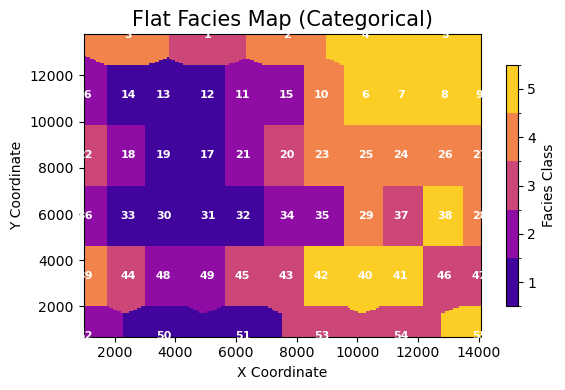

In [38]:
x = df['bh_x']
y = df['bh_y']
c = df['facies']

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use NEAREST interpolation for categorical data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='nearest')

# Define discrete colormap (you can customize colors)
facies_values = np.sort(df['facies'].unique())
n_facies = len(facies_values)
colors = plt.cm.plasma(np.linspace(0.1, 0.9, n_facies))
cmap = ListedColormap(colors)

# Set up discrete normalization boundaries
bounds = np.arange(facies_values.min() - 0.5, facies_values.max() + 1.5, 1)
norm = BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, s=40)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(
        xi, yi, str(df.index[i] + 1),  # label = row index
        color='white', fontsize=8, fontweight='bold',
        ha='center', va='center', zorder=4
    )

plt.title('Flat Facies Map (Categorical)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Discrete colorbar with labels for each facies
cbar = plt.colorbar(pcm, shrink=0.8, ticks=facies_values)
cbar.set_label('Facies Class')
plt.tight_layout()
plt.show()


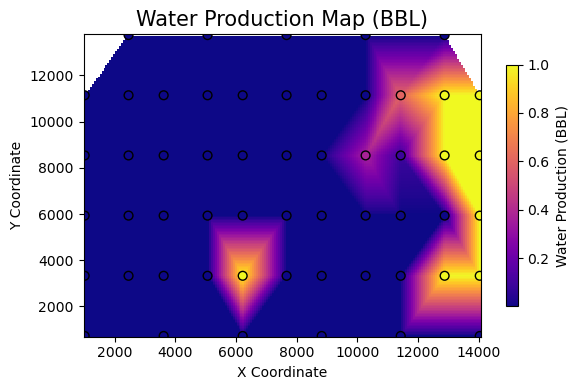

In [39]:
x = df['bh_x']
y = df['bh_y']
c = df['water_prod_bbl']  # continuous variable
c = np.clip(c, 0, 1)

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Water Production Map (BBL)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Water Production (BBL)')
plt.tight_layout()
plt.show()


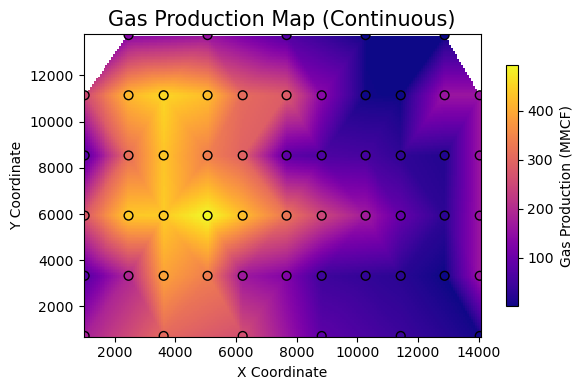

In [40]:
x = df['bh_x']
y = df['bh_y']
c = df['gas_prod_mmcf']  # continuous variable

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Gas Production Map (Continuous)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Gas Production (MMCF)')
plt.tight_layout()
plt.show()


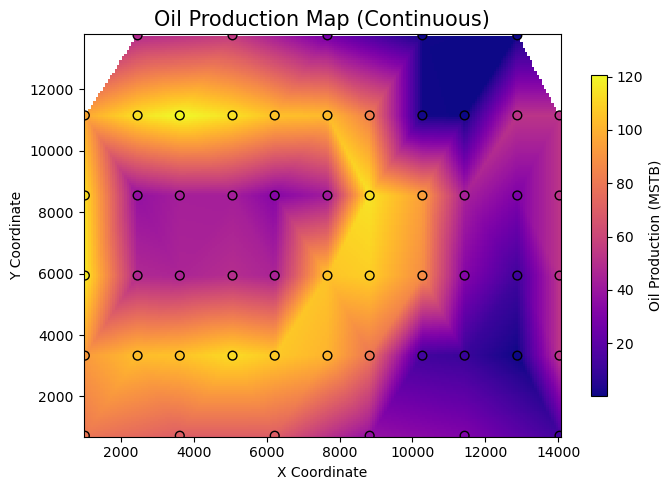

In [41]:
x = df['bh_x']
y = df['bh_y']
c = df['oil_prod_mstb']  # continuous variable

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(7, 5))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Oil Production Map (Continuous)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Oil Production (MSTB)')
plt.tight_layout()
plt.show()


In [42]:
# One-hot encode facies since it is categorical
df = pd.get_dummies(df, columns=['facies'], drop_first=True)

# Rearrange columns: well coordinates, production amounts, rock info, and dates
df = df[['bh_x', 'bh_y', 'total_depth_md', 'oil_prod_mstb', 'water_prod_bbl', 'gas_prod_mmcf', 'perm_x', 'perm_y', 'porosity', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'past_pressure', 'future_pressure']]
df.head()

,bh_x,bh_y,total_depth_md,oil_prod_mstb,water_prod_bbl,gas_prod_mmcf,perm_x,perm_y,porosity,facies_2,facies_3,facies_4,facies_5,past_pressure,future_pressure
0,5064.04,13746.23,8551.7,55.191600,1.617450e-04,157.119447,0.020377,0.020377,0.128029,False,True,False,False,3491.971374,2992.403113
1,7668.40,13746.23,8579.9,27.529400,1.394790e-04,69.831076,0.015088,0.015088,0.101876,False,False,True,False,3501.327981,2947.374808
2,2459.67,13746.23,8557.1,48.354000,1.973990e-04,134.781940,0.022396,0.022396,0.119220,False,False,True,False,3493.763065,2904.053641
3,10272.76,13746.23,8635.5,0.572057,1.440000e-07,1.101210,0.000091,0.000091,0.064132,False,False,False,True,3519.775759,3301.826052
4,12877.11,13746.23,8718.6,0.430394,8.560000e-08,0.435085,0.000067,0.000067,0.063078,False,False,False,True,3547.347889,3365.597401


In [43]:
# missing = df[(df == 0).any(axis=1)]
# missing

C:\Users\shake\AppData\Local\Temp\ipykernel_49560\1786411911.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df, labels=df.columns)


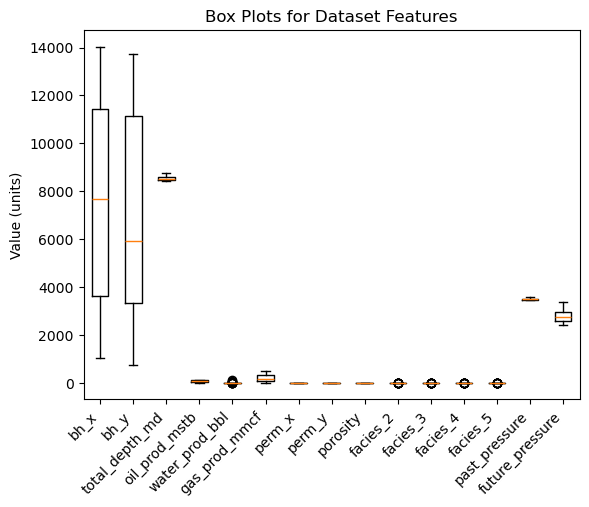

In [44]:
# Boxplots to check for outliers
plt.boxplot(df, labels=df.columns)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Value (units)')
plt.title('Box Plots for Dataset Features')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_49560\700364222.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])


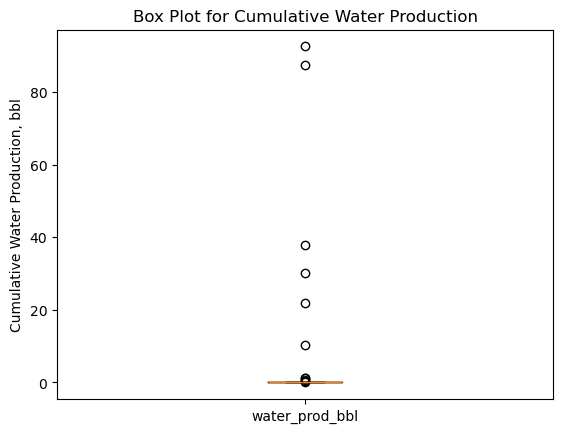

In [45]:
# Water production box plot
plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])
plt.title('Box Plot for Cumulative Water Production')
plt.ylabel('Cumulative Water Production, bbl')
plt.show()

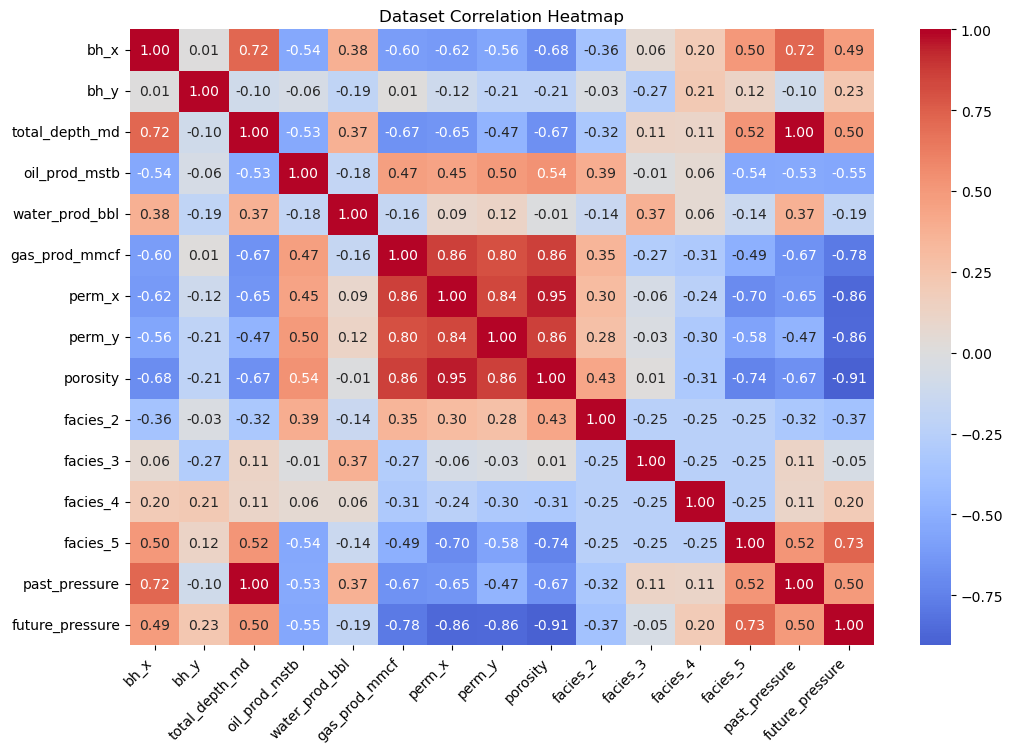

In [46]:
# Heatmap to display correlations
correlation_matrix = df.corr()
# correlation_matrix = correlation_matrix[['oil_prod_mstb']]
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Dataset Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

In [47]:
perm = 2 * df['perm_x'].astype(float) * df['perm_y'].astype(float) / (df['perm_x'].astype(float) + df['perm_y'].astype(float))
print(perm)

0     0.020377
1     0.015088
2     0.022396
3     0.000091
4     0.000067
5     0.000168
6     0.000162
7     0.000270
8     0.000284
9     0.015151
10    0.038947
11    0.050873
12    0.056463
13    0.052861
14    0.037831
15    0.034999
16    0.027062
17    0.019848
18    0.024499
19    0.013012
20    0.021804
21    0.012884
22    0.012158
23    0.004877
24    0.008402
25    0.009065
26    0.015409
27    0.012573
28    0.022922
29    0.053718
30    0.058151
31    0.047167
32    0.050863
33    0.036493
34    0.030338
35    0.038392
36    0.013927
37    0.004137
38    0.009499
39    0.003991
40    0.002784
41    0.004627
42    0.017898
43    0.026014
44    0.038956
45    0.038350
46    0.038000
47    0.041674
48    0.042639
49    0.055685
50    0.044984
51    0.034241
52    0.016377
53    0.012992
54    0.004627
dtype: float64


In [71]:
# Add harmonic mean permeability to dataframe
df['perm_hm'] = perm
df.head()

,bh_x,bh_y,total_depth_md,oil_prod_mstb,water_prod_bbl,gas_prod_mmcf,porosity,facies_2,facies_3,facies_4,facies_5,past_pressure,future_pressure,perm,perm_hm
0,5064.04,13746.23,8551.7,55.191600,1.617450e-04,157.119447,0.128029,False,True,False,False,3491.971374,2992.403113,0.020377,0.020377
1,7668.40,13746.23,8579.9,27.529400,1.394790e-04,69.831076,0.101876,False,False,True,False,3501.327981,2947.374808,0.015088,0.015088
2,2459.67,13746.23,8557.1,48.354000,1.973990e-04,134.781940,0.119220,False,False,True,False,3493.763065,2904.053641,0.022396,0.022396
3,10272.76,13746.23,8635.5,0.572057,1.440000e-07,1.101210,0.064132,False,False,False,True,3519.775759,3301.826052,0.000091,0.000091
4,12877.11,13746.23,8718.6,0.430394,8.560000e-08,0.435085,0.063078,False,False,False,True,3547.347889,3365.597401,0.000067,0.000067


In [72]:
columns_to_scale = ['perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf', 'total_depth_md', 'water_prod_bbl']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)
# Scale the relevant columns between 0 and 1
scale = MinMaxScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scale.fit_transform(df[columns_to_scale])

In [74]:
df_scaled.head()

,bh_x,bh_y,total_depth_md,oil_prod_mstb,water_prod_bbl,gas_prod_mmcf,porosity,facies_2,facies_3,facies_4,facies_5,past_pressure,future_pressure,perm,perm_hm
0,5064.04,13746.23,0.353722,0.456891,1.745744e-06,0.317443,0.511559,False,True,False,False,3491.971374,2992.403113,0.020377,0.349677
1,7668.40,13746.23,0.435084,0.227703,1.505296e-06,0.140991,0.305572,False,False,True,False,3501.327981,2947.374808,0.015088,0.258610
2,2459.67,13746.23,0.369302,0.400240,2.130768e-06,0.272288,0.442178,False,False,True,False,3493.763065,2904.053641,0.022396,0.384431
3,10272.76,13746.23,0.595499,0.004355,6.306559e-10,0.002056,0.008303,False,False,False,True,3519.775759,3301.826052,0.000091,0.000422
4,12877.11,13746.23,0.835257,0.003181,0.000000e+00,0.000709,0.000000,False,False,False,True,3547.347889,3365.597401,0.000067,0.000000


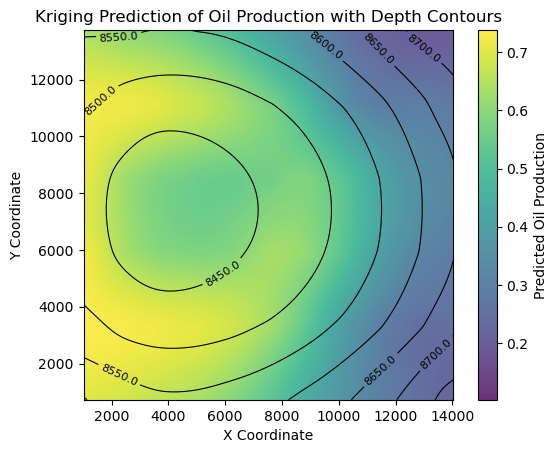

In [78]:
# Kriging interpolation and contour plotting (Oil Production)
# Coordinates and variables
x = df['bh_x']
y = df['bh_y']
oil_prod = df_scaled['oil_prod_mstb']    # For prediction surface
depth = df['total_depth_md']      # For contour lines

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Kriging interpolation for oil production
OK_oil = OrdinaryKriging(x, y, oil_prod, variogram_model='linear')
z_oil_pred, ss_oil = OK_oil.execute('grid', grid_x[:,0], grid_y[0,:])

# Kriging interpolation for depth (to get smooth contour lines)
OK_depth = OrdinaryKriging(x, y, depth, variogram_model='linear')
z_depth_pred, ss_depth = OK_depth.execute('grid', grid_x[:,0], grid_y[0,:])

# Plot oil production predicted surface
plt.imshow(z_oil_pred, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', alpha=0.8)
plt.colorbar(label='Predicted Oil Production')

# Overlay contour lines of depth
contour = plt.contour(grid_x[:,0], grid_y[0,:], z_depth_pred, colors='black', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')

plt.title('Kriging Prediction of Oil Production with Depth Contours')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

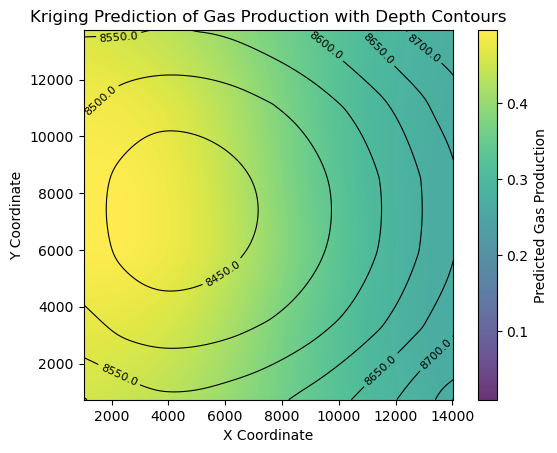

In [76]:
# Kriging interpolation and contour plotting (Gas Production)
# Coordinates and variables
x = df['bh_x']
y = df['bh_y']
gas_prod = df_scaled['gas_prod_mmcf']    # For prediction surface
depth = df['total_depth_md']      # For contour lines

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Kriging interpolation for oil production
OK_gas = OrdinaryKriging(x, y, gas_prod, variogram_model='linear')
z_gas_pred, ss_gas = OK_gas.execute('grid', grid_x[:,0], grid_y[0,:])

# Kriging interpolation for depth (to get smooth contour lines)
OK_depth = OrdinaryKriging(x, y, depth, variogram_model='linear')
z_depth_pred, ss_depth = OK_depth.execute('grid', grid_x[:,0], grid_y[0,:])

# Plot oil production predicted surface
plt.imshow(z_gas_pred, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', alpha=0.8)
plt.colorbar(label='Predicted Gas Production')

# Overlay contour lines of depth
contour = plt.contour(grid_x[:,0], grid_y[0,:], z_depth_pred, colors='black', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')

plt.title('Kriging Prediction of Gas Production with Depth Contours')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

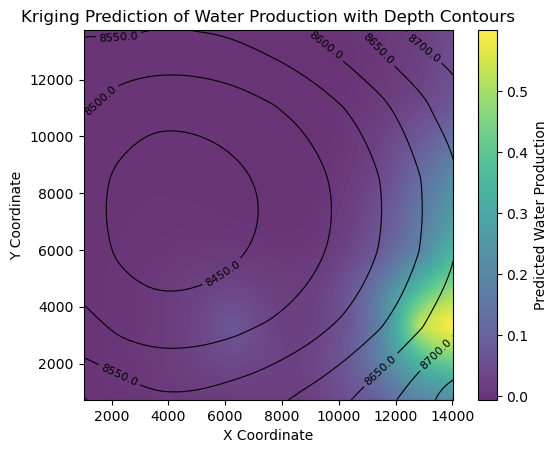

In [77]:
# Kriging interpolation and contour plotting (Water production)
# Coordinates and variables
x = df['bh_x']
y = df['bh_y']
water_prod = df_scaled['water_prod_bbl']    # For prediction surface
depth = df['total_depth_md']      # For contour lines

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Kriging interpolation for water production
OK_water = OrdinaryKriging(x, y, water_prod, variogram_model='linear')
z_water_pred, ss_water = OK_water.execute('grid', grid_x[:,0], grid_y[0,:])

# Kriging interpolation for depth (to get smooth contour lines)
OK_depth = OrdinaryKriging(x, y, depth, variogram_model='linear')
z_depth_pred, ss_depth = OK_depth.execute('grid', grid_x[:,0], grid_y[0,:])

# Plot water production predicted surface
plt.imshow(z_water_pred, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', alpha=0.8)
plt.colorbar(label='Predicted Water Production')

# Overlay contour lines of depth
contour = plt.contour(grid_x[:,0], grid_y[0,:], z_depth_pred, colors='black', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')

plt.title('Kriging Prediction of Water Production with Depth Contours')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()